# Part II. Training and Testing the Final Model in Python

## II.a Processing the reviews and obtaining final vocabulary

First, import all libraries

In [1]:
import pandas as pd
import sklearn
import string
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import metrics
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

Then, import and load the vocabulary with 1005 words to a list (the number of terms will be trimmed down to 980 later):

In [2]:
words = pd.read_csv("myvocab2.csv")
word_list = list(words['x'])

Now, pre-process the text: removing all punctuations and replacing underscores with blank space

In [3]:
vocabR = []
for word in word_list:
    vocabR.append(word.translate(str.maketrans('_',' ','')).lower())
vocab2R = []
for word in vocabR:
    vocab2R.append(word.translate(str.maketrans('','',string.punctuation)).lower())

Now, we read all review texts from "alldata.tsv" and remove punctuation. We also had to remove words ending with "br" since it is a html code and not part of the text.

In [4]:
df = pd.read_table("alldata.tsv")
sentiment_list = list(df['sentiment'])
corpus = []

for document in df['review']:
    clean = document.translate(str.maketrans('','',string.punctuation)).lower()
    words = clean.split()
    filtered = []
    for word in words:
        if word[len(word) - 2] == 'b' and word[len(word) - 1] == 'r':
                word = word[0:(len(word) - 2)]
        filtered.append(word)
    new_string = ' '.join(filtered)
    corpus.append(new_string)

Now, we will vectorize all reviews, where each review will be mapped to a vector with dimension equal to the number of N-grams in the vocabulary. We will use the bag-of-words model for this step.

The bag-of-words model of a text is similar to a one-hot encoding of a word, except that the value of each feature in the encoded vector is not necessarily 1 or 0, but how many times the N-gram corresponding to that feature occurs in that review.

In [5]:
vectorizer = CountVectorizer(ngram_range = (1,4))
Xc = vectorizer.fit_transform(corpus)
names = vectorizer.get_feature_names_out()
vocab_size = len(names)
print(vocab_size)

18613240


Thus, the vocabulary size is 18613240. Let's see some of the N-grams extracted from the reviews:

In [6]:
print(names[:10])

['00' '00 agent' '00 agent difficult' '00 agent difficult level'
 '00 agent level' '00 agent level is' '00 comes' '00 comes back'
 '00 comes back from' '00 for']


Now, from these 18613240 N-grams, we will only keep the ones that are inside the vocabulary found in R:

In [7]:
inds = []

for i in range(vocab_size):
    if names[i] in vocab2R:
        inds.append(i)

The number of terms of the vocabulary in Python is 980:

In [8]:
print('The Python dictionary has',len(names[inds]),'terms')


The Python dictionary has 980 terms


Let's save the final vocabulary to a csv file:

In [9]:
final_vocab = pd.DataFrame(names[inds])
final_vocab.to_csv('final_vocab.cvs', index = False)

## II.b Neural Network model

The Python model is a neural network. To run the final model, we need the inputs X and outputs y.

The inputs are the columns in the vectorized review matrix which correspond to the terms in the vocabulary. The output is the sentiment of each review. Later we split X and Y into train and test data.

Both X and y are transformed to numpy arrays:

In [10]:
X = np.array(Xc[:,inds].toarray())
y = np.array(sentiment_list)

Now let's separate X and y intro train and test data. Let's take the first split, which is found by taking the review indices in the first column of 'project3_splits.csv':


In [11]:
train_test_df = pd.read_csv('project3_splits.csv')
test_ind = np.array(list(train_test_df['split_1']))-1
train_ind = np.array(list(set(list(range(0,50000)))-set(test_ind)))
traindata = X[train_ind]
trainlabels = y[train_ind]
testdata = X[test_ind]
testlabels = y[test_ind]

Finally let's run the neural network (NN) model. It has one hidden layer with 20 inputs, with ReLU activation. The output is a single number between 0 and 1, obtained by the sigmoid function. We train all NN for 20 epochs. Each split takes only a few seconds to run.

In [12]:
model = Sequential()
model.add(Dense(20, input_shape=(980,), activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', metrics=[metrics.AUC()])
model.fit(traindata, trainlabels, epochs=20, verbose=2)

Epoch 1/20
782/782 - 3s - loss: 0.3339 - auc: 0.9386 - 3s/epoch - 3ms/step
Epoch 2/20
782/782 - 1s - loss: 0.2453 - auc: 0.9638 - 863ms/epoch - 1ms/step
Epoch 3/20
782/782 - 1s - loss: 0.2354 - auc: 0.9667 - 875ms/epoch - 1ms/step
Epoch 4/20
782/782 - 1s - loss: 0.2292 - auc: 0.9684 - 860ms/epoch - 1ms/step
Epoch 5/20
782/782 - 1s - loss: 0.2250 - auc: 0.9696 - 866ms/epoch - 1ms/step
Epoch 6/20
782/782 - 1s - loss: 0.2215 - auc: 0.9704 - 919ms/epoch - 1ms/step
Epoch 7/20
782/782 - 1s - loss: 0.2186 - auc: 0.9711 - 896ms/epoch - 1ms/step
Epoch 8/20
782/782 - 1s - loss: 0.2167 - auc: 0.9717 - 874ms/epoch - 1ms/step
Epoch 9/20
782/782 - 1s - loss: 0.2137 - auc: 0.9724 - 880ms/epoch - 1ms/step
Epoch 10/20
782/782 - 1s - loss: 0.2121 - auc: 0.9729 - 814ms/epoch - 1ms/step
Epoch 11/20
782/782 - 1s - loss: 0.2105 - auc: 0.9733 - 832ms/epoch - 1ms/step
Epoch 12/20
782/782 - 1s - loss: 0.2083 - auc: 0.9738 - 835ms/epoch - 1ms/step
Epoch 13/20
782/782 - 1s - loss: 0.2065 - auc: 0.9743 - 846ms/ep

Finally, let's evaluate the AUC of the trained NN on the test data:


In [13]:
Ypred = model.predict(testdata)
print(roc_auc_score(testlabels, Ypred))

782/782 [==============================] - 1s 846us/step
0.962114226440135


For all 5 splits, the AUC is bigger than 0.96. Finally, let's visualize the ROC:



Text(0, 0.5, 'True positive rate')

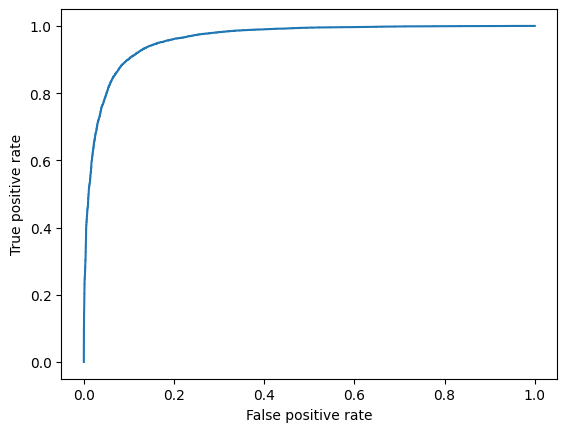

In [14]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(testlabels, Ypred)
plt.plot(fpr_keras, tpr_keras)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")